
# Project 1: Digit Classification with KNN


# Intro
---
In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. 
As always, you're welcome to work on the project in groups and discuss ideas over Slack, but <b> please prepare your own write-up (with your own code). </b> To be safe, please credit any sources used.


## Grading
---
 - Make sure to answer every part in every question.
 - There are 5 questions, each worth an equal number of points.
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean or is not well commented
   - the functions or answers are excessively long

## Requirements:
---
1. Comment your code.
1. Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning, keep things inside functions).

## Additional reading and notes
---

If you are looking to get started with Tensorflow, you can read through this tutorial: https://www.tensorflow.org/tutorials/keras/classification. It uses a dataset called "fashion_mnist", which is identical in structure to the original digit mnist, but uses images of clothing rather than images of digits. The number of training examples and number of labels is the same. In fact, you can simply replace the code that loads "fashion_mnist" with "mnist" and everything should work fine.

Additionally, if you're interested, check out these links related to digit recognition:

* Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/
* Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [2]:
import sklearn
sklearn.__version__

'0.24.2'

Load the data. Notice that the data gets partitioned into training, development, and test sets. Also, a small subset of the training data called mini_train_data and mini_train_labels gets defined, which you should use in all the experiments below, unless otherwise noted.

In [3]:
# Load the digit data from https://www.openml.org/d/554 or from default local location '~/scikit_learn_data/...'
X, Y = fetch_openml(name='mnist_784', return_X_y=True, cache=False, as_frame=False)

In [4]:
# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


### Question 1: Visualize a select sample of images
---
Show a 10x10 grid that visualizes 10 examples of each digit.

Notes:
* Make the digits nice and big.
* You can use `plt.rc()` for setting the colormap, for example to black and white.
* You can use `plt.subplot()` for creating subplots.
* You can use `plt.imshow()` for rendering a matrix.
* You can use `np.array.reshape()` for reshaping a 1D feature vector into a 2D matrix (for rendering).

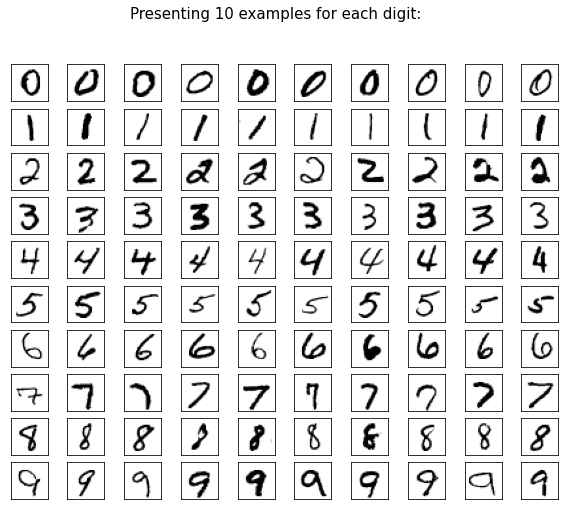

In [5]:
def Q1(train_labels, num_examples=10):
  ### STUDENT START ###

    counter = [0] * 10  #Array to count number of examples for each digit
    
    #Ensure num_examples is positive and greater than zero (by default minimum value is 1)
    if num_examples == 0: x=1 
    else: num_examples=abs(num_examples)    

    #Create figure2 with number of subplots to accomodate number of examples
    fig2, axs_q2 = plt.subplots(nrows=10, ncols=num_examples, figsize=(num_examples, 8))

    # Turn off tick marks.
    plt.setp(axs_q2, xticks=(), yticks=())

    not_finished, i = True, 0
    tot_finish = 10 * num_examples  #Variable to check if total number of examples has been achieved.
    
    #Loop to include number of examples of each digit in the plot.  Finish when all digits reach number of examples.
    while not_finished:
        if sum(counter) == tot_finish:
            not_finished = False
        else:
            num = int(train_labels[i])  #Read current number
            if counter[num] < num_examples:  #If not reached limit of number of examples, include image in the plot
                
                #Manage special case when number of examples is equal to one (1-d plot), otherwise include in 2-d plot.
                if num_examples == 1: 
                    axs_q2[num].imshow(np.reshape(train_data[i,:],(28,28)), cmap=plt.cm.Greys)
                else:
                    axs_q2[num, counter[num]].imshow(np.reshape(train_data[i,:],(28,28)), cmap=plt.cm.Greys)
                counter[num] += 1
        i += 1
    
    fig2.suptitle('Presenting {} examples for each digit:'.format(num_examples), fontsize=15, )
    plt.show()
    
  ### STUDENT END ###

Q1(train_labels,10)


### Question 2: Evaluating different choices of k
---

1. Produce k-Nearest Neighbors models with k = 1, 3, 5, 7, and 9.  
1. Print the accuracy of each model. 
1. Additionally, only for the 1-Nearest Neighbor model, show the precision, recall, and F1 for each label. 
1. Which digit is the most *difficult* for the 1-Nearest Neighbor model to classify correctly? How did you choose and why?

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.
* Print only the information asked so it is easy to read and compare.
* You can use `KNeighborsClassifier` to produce a k-nearest neighbor model.
* You can use `classification_report` to get precision, recall, and F1 results.
* Check out what the function "score" does.

In [6]:
def Q2(train_data, train_labels, k_values):

### STUDENT START ###
    
    #List to store accuracy scores for models
    accuracy = []
    
    #Loop to create models & store accuracy metric
    for k in k_values:
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(train_data, train_labels)
        dev_predicted_labels = model.predict(dev_data)
        if k == 1: #Save Classification Report for k=1
            class_report = classification_report(dev_labels,dev_predicted_labels)
        accuracy.append(model.score(dev_data,dev_labels))
        
    #Create Dataframe with key statistics for each model
    df_KN_accuracy = pd.DataFrame({"K": k_values, "Accuracy": accuracy})
    print("Accuracy for K-Nearest Neighbor Models:")
    print(df_KN_accuracy)
    print("\n Classification Report for 1-Nearest Neighbor Model:")
    print(class_report)

### STUDENT END ###

k_values = [1, 3, 5, 7, 9]
cr_output = Q2(mini_train_data, mini_train_labels, k_values)

Accuracy for K-Nearest Neighbor Models:
   K  Accuracy
0  1     0.884
1  3     0.876
2  5     0.882
3  7     0.877
4  9     0.875

 Classification Report for 1-Nearest Neighbor Model:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       106
           1       0.89      0.98      0.93       118
           2       0.90      0.79      0.84       106
           3       0.93      0.87      0.90        97
           4       0.91      0.85      0.88        92
           5       0.86      0.88      0.87        88
           6       0.92      0.92      0.92       102
           7       0.85      0.94      0.89       102
           8       0.83      0.77      0.80        94
           9       0.80      0.86      0.83        95

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.89      0.88      0.88      1000



**Answer to part 4:**  *Which digit is the most difficult for the 1-Nearest Neighbor model to classify correctly? How did you choose and why? (From OH: Use the recall measurement to compare performance accross digits, and overall accuracy to compare the models)>*  
Using the recall metric, the most difficult digit to classify by 1-Nearest Neighbor Model is number 8, with a recall rate of 0.77.  
Recall is the ability of a classifier to find all positive instances. For each class it is defined as the ratio of true positives to the sum of true positives and false negatives, which makes it a better metric to compare performance across digits within the model.  
Recall = TP/(TP+FN)

### Question 3: Examining the importance of training size
---
1. Produce 1-Nearest Neighbor models using training data of various sizes. For example, ```train_data[:train_size]```.
1. Evaluate and show the accuracy achieved by each model.  
1. Show the time needed to: 
  1. Train each model.
  1. Measure the accuracy of each model.
1. What do you see? Is this what you expected to see and why?
1. Plot on the same graph (as a function of training size):
  1. the time needed for training
  1. the time needed for calculating accuracy

Notes:
* Evaluate on the dev set.
* You can use `KNeighborsClassifier` to produce a k-nearest neighbor model.
* You can use `time.time()` to measure elapsed time of operations.

   Train_sizes  Accuracy  Train Times  Eval_times
0          100     0.702     0.000963    0.031731
1          200     0.791     0.000000    0.029001
2          400     0.811     0.000000    0.036000
3          800     0.866     0.002000    0.042030
4         1600     0.905     0.002001    0.058014
5         3200     0.927     0.004697    0.090555
6         6400     0.939     0.011999    0.157999
7        12800     0.952     0.020000    0.284093
8        25600     0.963     0.040001    0.559104


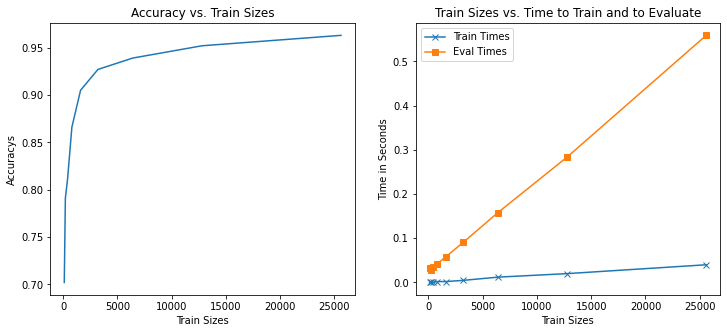

In [7]:
def Q3(train_sizes, accuracies, train_times, eval_times, train_data, train_labels, dev_data, dev_labels):

### STUDENT START ###
    
    k = 1

    for ts in train_sizes:
        
        # Set data for test, dev, and training data.     
        td, tl = train_data[:ts], train_labels[:ts]
        
        #Create model for k=1
        model_q3 = KNeighborsClassifier(n_neighbors=k)
        
        #Fit the model with a given training set, and store time to fit the model.
        start_train = time.time()                  
        model_q3.fit(td, tl)    
        stop_train = time.time()                   
        train_times.append(stop_train-start_train)
        
        #Calculate accuracy and store time to measure accuracy
        start_acc = time.time()
        accuracy = model_q3.score(dev_data, dev_labels)
        stop_acc = time.time()
        eval_times.append(stop_acc - start_acc)
        accuracies.append(accuracy)
                
### STUDENT END ###

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600]
accuracies = []
train_times = []
eval_times = []
Q3(train_sizes, accuracies, train_times, eval_times, train_data, train_labels, dev_data, dev_labels)

#Create and Print Data Frame to store the train sizes, accuracies, train times and evaluation times.
df_summary = pd.DataFrame({"Train_sizes": train_sizes,
                           "Accuracy": accuracies,
                           "Train Times": train_times,
                           "Eval_times": eval_times})

print(df_summary)

#Create figure2 with number of subplots to accomodate number of examples
fig3, axs_q3 = plt.subplots(nrows=1, ncols=2,figsize=(12, 5))

axs_q3[1].plot(train_sizes, train_times, marker="x", label = "Train Times")
axs_q3[1].plot(train_sizes, eval_times, marker="s", label = "Eval Times")

#Graph to present time to train and to evaluate vs. Trains Sizes
axs_q3[1].set_xlabel("Train Sizes")
axs_q3[1].set_ylabel("Time in Seconds")
axs_q3[1].set_title("Train Sizes vs. Time to Train and to Evaluate")
axs_q3[1].legend()

#Graph to present accuracy rate vs. Train Sizes
axs_q3[0].plot(train_sizes, accuracies)
axs_q3[0].set_title("Accuracy vs. Train Sizes")
axs_q3[0].set_ylabel("Accuracys")
axs_q3[0].set_xlabel("Train Sizes")

plt.show()

**4 - What do you see?** *Is this what you expected to see and why?*   
- As expected, as the train size increases, both the evaluation and the train times increase.
- Also, as expected, k-Nearest Neighbor Models take relatively short time to be fitted.  KNN is known as a lazy model which does not make calculations when fitting it.  However, KNN models take more time to evaluate, as the model makes the calculation for the distance between points at this stage to identify the nearest neighbor (thsu, evaluation time is larger).

### Question 4: Evaluating if we should obtain additional data
---

In this question we wish to predict what accuracy we would get if we had additional training data.

Our input, our features and labels, are the output from the previous question. Based on the training size and accuracy we got in the previous question, we wish to predict the accuracy we would get if we had larger training sizes.

1. Produce a linear regression model that predicts accuracy of a 1-Nearest Neighbor model given training set size. 
1. Print $R^2$ of the linear regression model.  
1. Print the accuracies predicted for training set sizes 60000, 120000, and 1000000.  
1. Plot on a lineplot graph:
  1. the actual accuracies we obtained in the previous question 
  1. and the accuracies our model predicted we would have gotten.
  1. The X axis is the training set size. 
  1. You can limit the range of X and Y to the range where you have data for both plots. Meaning, in the this question, we want to visualize how good the prediction is.
1. What are two things that are wrong with our model?
1. Apply a transformation to the predictor features and a transformation to the outcome that make the predictions fix these issues. 
1. Show $R^2$ of the improved linear regression model.  
1. Print the accuracies predicted for training set sizes 60000, 120000, and 1000000.  
1. Plot a lineplot graph of both again as before.
  1. Be sure to plot this where the Y axis is accuracy and X axis is training set size, **not the transformed space**!
  1. Choose the range of X and Y to visualize effectively.

Notes:
* Train the linear regression models on all of the (transformed) accuracies estimated in Problem 3.
* Evaluate the linear regression models on all of the (transformed) accuracies estimated in Problem 3.
* You can use `LinearRegression` to produce a linear regression model.
* Remember that the sklearn `fit()` functions take an input matrix X and output vector Y. So, each input example in X is a vector, even if it contains only a single value.
* Hints:
  1. You have two problems here, how well your model fits and predicting *illogical* values of accuracy.
  1. You can look at:
    1. [logit](https://en.wikipedia.org/wiki/Logit): $\frac{1}{1 + e^{-x}} = \frac{e^x}{1+e^x}$ which takes numbers in $\[\infty,-\infty\]$ and outputs numbers in $(0, 1)$.
    1. [logistic](https://en.wikipedia.org/wiki/Logistic_function): $log(\frac{p}{1 - p})$ which takes numbers between $(0, 1)$ and outputs numbers between $\[\infty,-\infty\]$.
    1. It also happens that $x = logistic(p)$ is the same thing as $logit(x)=p$.


Accuracy Predictions from Simple Linear Model:
R-sqr: 0.4177
   Train Size  Acc_Predi
0       60000   1.236173
1      120000   1.637428
2     1000000   7.522500


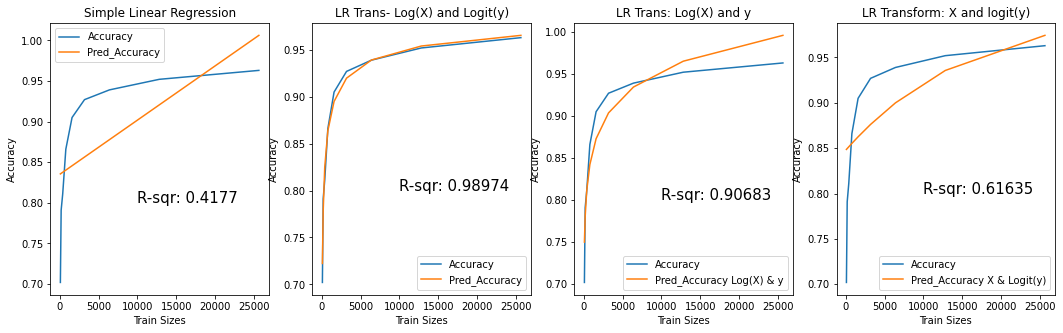


Accuracy Predictions Best Performing Model:
** LR Trans- Log(X) and Logit(y) **
R-sqr: 0.98974
   Train Size  Acc_Predi
0       60000   0.975753
1      120000   0.981867
2     1000000   0.992606


In [9]:
def Q4(df_summary):

### STUDENT START ###

    #Initialize input and output: y = Accuracies from Q3, X = Training Sizes from Q3
    y = df_summary["Accuracy"]
    X = df_summary[["Train_sizes"]].values

    #Reshape train sizes to be used with model
    train_sizes_input = np.array(train_sizes).reshape(len(train_sizes),1)

    #Create and fit Simple linear Regression Model
    model_lr = LinearRegression(fit_intercept=True)
    model_lr.fit(X,y)
    predict_lr1 = model_lr.predict(train_sizes_input)

    #Get predictions for 60000, 120000, 1000000 (using simple linear model), and print them.
    ts = np.array([60000, 120000, 1000000])
    df_predict = pd.DataFrame({"Train Size": ts, 
                               "Acc_Predi": model_lr.predict(ts.reshape(len(ts),1))})

    print("\nAccuracy Predictions from Simple Linear Model:")
    print("R-sqr: "+str( round(model_lr.score(X, y),5)  ) )
    print(df_predict)

    #Logit and Logistic functions defined 
    logit = lambda x : np.log( x / (1-x))
    logistic = lambda x: 1 / (1 + np.exp(-x))
    
    #logit to transform y
    y_logit = logit(y)
    
    #log tranformation for X
    X_log = np.log(X)

    #Create model, fit and get predictions for linear model using logit transformed y and log for X 
    model_logit = LinearRegression(fit_intercept=True)
    model_logit.fit(X_log, y_logit)
    predict_lr_logit = model_logit.predict(np.log(train_sizes_input))

    #Create model, fit and get predictions for linear model using log transformed X and no transformation for y 
    model_lr2 = LinearRegression(fit_intercept=True)
    model_lr2.fit(X_log, y)
    predict_lr2 = model_lr2.predict(np.log(train_sizes_input))

    #Create model, fit and get predictions for linear model using X and logit transformation for y 
    model_lr3 = LinearRegression(fit_intercept=True)
    model_lr3.fit(X, y_logit)
    predict_lr3 = model_lr3.predict(train_sizes_input)

    #Create figure with 2 subplots
    fig4, axs_q4 = plt.subplots(nrows=1, ncols=4,figsize=(18, 5))
    px, py = 10000, 0.8

    #Plot for Simple Regression Model - Predictions vs. Real Accuracy for Train Sizes
    axs_q4[0].plot(train_sizes, accuracies, label = "Accuracy")
    axs_q4[0].plot(train_sizes, predict_lr1, label = "Pred_Accuracy")
    axs_q4[0].set_title("Simple Linear Regression")
    axs_q4[0].set_ylabel("Accuracy")
    axs_q4[0].set_xlabel("Train Sizes")
    axs_q4[0].legend()
    axs_q4[0].text(px, py, "R-sqr: "+str( round(model_lr.score(X, y),5)  ), fontsize=15)

    #Plot for Linear Regression with Logit/Log Transformed y and X - Prediction vs. Real Accuracy for Train Sizes
    axs_q4[1].plot(train_sizes, accuracies, label = "Accuracy")
    axs_q4[1].plot(train_sizes, logistic(predict_lr_logit), label = "Pred_Accuracy")
    axs_q4[1].set_title("LR Trans- Log(X) and Logit(y)")
    axs_q4[1].set_ylabel("Accuracy")
    axs_q4[1].set_xlabel("Train Sizes")
    axs_q4[1].legend()
    axs_q4[1].text(px, py, "R-sqr: "+ str(round(model_logit.score(X_log, y_logit),5)), fontsize=15)

    #Plot for Linear Regression with Logit/Log Transformed y and X - Prediction vs. Real Accuracy for Train Sizes
    axs_q4[2].plot(train_sizes, accuracies, label = "Accuracy")
    axs_q4[2].plot(train_sizes, predict_lr2, label = "Pred_Accuracy Log(X) & y")
    axs_q4[2].set_title("LR Trans: Log(X) and y")
    axs_q4[2].set_ylabel("Accuracy")
    axs_q4[2].set_xlabel("Train Sizes")
    axs_q4[2].legend()
    axs_q4[2].text(px, py, "R-sqr: "+ str(round(model_lr2.score(X_log, y),5)), fontsize=15)

    #Plot for Linear Regression with Logit Transformed y and No transformation for X
    axs_q4[3].plot(train_sizes, accuracies, label = "Accuracy")
    axs_q4[3].plot(train_sizes, logistic(predict_lr3), label = "Pred_Accuracy X & Logit(y)")
    axs_q4[3].set_title("LR Transform: X and logit(y)")
    axs_q4[3].set_ylabel("Accuracy")
    axs_q4[3].set_xlabel("Train Sizes")
    axs_q4[3].legend()
    axs_q4[3].text(px, py, "R-sqr: "+ str(round(model_lr3.score(X, y_logit),5)), fontsize=15)
  
    plt.show()

    #Get predictions and print them, using logit/log transformation model, for 60000, 120000, 1000000
    ts_logit = np.log(ts)
    pr_logit = model_logit.predict(ts_logit.reshape(len(ts_logit),1))
    df_predict = pd.DataFrame({"Train Size": ts, 
                               "Acc_Predi": logistic(pr_logit)})

    print("\nAccuracy Predictions Best Performing Model:")
    print("** LR Trans- Log(X) and Logit(y) **")
    print("R-sqr: "+ str(round(model_logit.score(X_log, y_logit),5)))
    print(df_predict)

### STUDENT END ###

Q4(df_summary)

**Answer to part 5:** *What are two things that are wrong with our model?*  
For predictions using Simple Linear regression (graph on the left), there are two things going wrong:    
(1) It is not appropriate to fit a linear model to a non-linear X,y relationship.  
(2) The prediction is not bound to the range 0 to 1.  Thus, predictions for larger sample sizes (i.e. 1000000), the accuracy is being predicted at around 7, which is not possible as accuracy score should be between 0 an 1.    
Thus, there is a need to explore transformations which help adjust values to these ranges.

### Question 5: Getting to know the confusion matrix.
---

1. Produce a 1-Nearest Neighbor model.
1. Show the confusion matrix. 
1. Which digit does the model most often confuse with which digit? (*for example, the model most often mistakes the digit $1$ as the digit $7$*).

1. Show examples of the misclassified digit.

Notes:
- Train on the mini train set.
- Evaluate performance on the dev set.
- You can use `confusion_matrix()` to produce a confusion matrix.
- No need to calculate the "most confused digits" programmatically.

Confusion Matrix:
     0    1   2   3   4   5   6   7   8   9
0  101    0   1   0   0   0   1   1   2   0
1    0  116   1   0   0   0   0   0   1   0
2    1    4  84   2   2   0   2   4   6   1
3    0    2   0  84   0   6   0   2   3   0
4    0    0   1   0  78   0   0   2   0  11
5    2    0   0   1   1  77   5   0   2   0
6    1    2   1   0   1   2  94   0   1   0
7    0    1   1   0   0   0   0  96   0   4
8    1    5   4   3   1   3   0   1  72   4
9    0    1   0   0   3   2   0   7   0  82

Digit 4, is 11 times mislabeled with digit 9 (most of all digits).


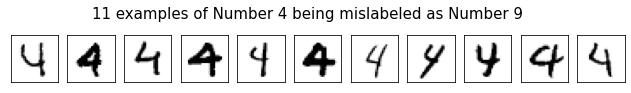

In [10]:
def Q5(train_data, train_labels, dev_data, dev_labels):

### STUDENT START ###

    k = 1 #Factor for KNN model
    
    #Create, fit and get prediction for KNN model (k=1)
    model_q5 = KNeighborsClassifier(n_neighbors=k)
    model_q5.fit(train_data, train_labels)
    dev_predicted_labels = model_q5.predict(dev_data)
    
    #Generate and print Confusion Matrix
    cfm = pd.DataFrame(confusion_matrix(dev_labels,dev_predicted_labels), columns=range(10), index=range(10))
    print ("Confusion Matrix:")
    print(cfm)
    
    #Find digit most mislabeled by another in confusion matrix (cfm)
    i, max_value = 1, 0
    for i in range(len(cfm)):
        for j in range(len(cfm)):
            if (i!=j) and (max_value < cfm.iloc[i,j]): 
                digit, confused_by, max_value = i, j, cfm.iloc[i,j]
    print ("\nDigit {}, is {} times mislabeled with digit {} (most of all digits).".format(digit, max_value, confused_by))
    
    #Filter and identify index positions in array where digit is most confused.
    filter1 = dev_labels != dev_predicted_labels
    list2 = np.where((dev_labels == str(digit)) & filter1 & (dev_predicted_labels == str(confused_by)))
                            
    #Create figure2 with number of subplots to accomodate number of examples
    fig5, axs_q5 = plt.subplots(nrows=1, ncols=len(list2[0]), figsize=(len(list2[0]), 1.5))
 
    # Turn off tick marks
    plt.setp(axs_q5, xticks=(), yticks=())
    
    # Present missed digits in plot
    j = 0
    for e in list2[0]:
        axs_q5[j].imshow(np.reshape(dev_data[e,:],(28,28)), cmap=plt.cm.Greys)
        j +=1

    fig5.suptitle('{} examples of Number {} being mislabeled as Number {}'.format(len(list2[0]),digit,confused_by), 
                  fontsize=15, )
    
    plt.show()
    
    ### STUDENT END ###

Q5(mini_train_data, mini_train_labels, dev_data, dev_labels)


**Answer to part 3:** *Which digit does the model most often confuse with which digit? (for example, the model most often mistakes the digit  1  as the digit  7 ).*  
The digit that is most frequently confused is 4 being mislabeled as a 9.  From confusion matrix, there are 11 situations where the real value was a 4, but it was mislabeled as a 9, which is the highest number of mislabels in the matrix.
